# Reading parquet the hard way

Parquet is a cloud-native data format suitable for a variety of data types, including geospatial vector data. It is often described as being "column-oriented", as opposed to row-oriented like traditional databases and vector formats (though in reality parquet is really more of a hybrid format, one not strictly columnar).

The cloud-native aspect of parquet mainly comes down to two facets of its design:

* file metadata is consolidated at the end of a file, and can be read entirely in at most two requests
* the metadata contains enough information for clients to selectively read only chunks that may contain targeted rows

## Predicate pushdown

This "selective reading" is done by a process called "predicate pushdown". Predicate pushdown enables clients to skip reading potentially massive amounts of data by leveraging things like chunk statistics and chunk bloom filters to restrict reads to only those chunks that _may_ potentially contain target data.

Consider an example like this SQL statement:

```sql
SELECT temperature
FROM dataset
WHERE
  st_intersects(geom, AOI)
  AND snow_cover_percent > 0
  AND precipitation >= 10
  AND land_cover NOT IN ("rock", "urban")
```

Here we see the user requesting the `temperature` variable from `dataset` records that have:

* a geometry interseting the AOI
* any snow cover
* some significant precipitation
* a non-impervious surface

Each of these conditions is called a predicate. Predicate pushdown means using predicates to filter what chunks to read from a file, or to even filter out whole files. File and chunk statistics provide a means of identifying files and chunks that cannot possibly have a record of interest per the query predicates, and skipping those. Of those remaining, bloom filters can provide another efficient check to eliminate chunks that cannot possibly contain target records. What chunks are left are then read and filtered by the client application using the actual values prior to returning the requested data.

Note the language "cannot possibly contain" is used here specifically: we never want to miss a matching record, so we use techniques that give us means of eliminating chunks with certainty that they will not contain a recod of interest. These techniques come with the trade off that false positives can occur: we can rarely know that chunk _does_ have a target record. Sometimes we then read chunks without target records, because that is the only way to ensure they do not have what we are looking for.

Generally though, predicate pushdown is an effective means of eliminating a large amount of data without having to read anything but metadata.

## The exercise

To get a deeper understanding of parquet and how it works, we're going to examine the [Overture Maps Buildings dataset](https://docs.overturemaps.org/guides/buildings). We will find the geometry for the building we're in for this workshop, the AUT School of Business building.

This exercise is perhaps a bit contrived, because we'll start with a rough geometry for the building that we traced from aerial imagery in exercise 1, but the principles we'll be demonstrating are applicable generally for clients wanting to read from parquet, and will show how that process works in some detail. Key to the process will be a focus on using predicate pushdown with geometries, and how we can use less expensive bounding box operations to more effiicently eliminate chunks and records before turning to more expensive real-geometry comparisons.

### The `por-que` library

To facilitate the learning experience, we'll use the author's custom python parquet parsing library, called `por-que`. This library is different from other, more efficient parsing libraries like `pyarrow`, in that it is designed for the educational experience. A core feature is the parsing of the entire file metadata, data page metadata, and byte structure of the file, which it exposes to users, unlike other tools that keep them hidden away as internal details.

`por-que` can export the entire parsed structure to JSON, which can then be loaded, visualized, and explored with the [`ver-por-que` web application](https://teotl.dev/ver-por-que/). We'll see all of this in action through the exercise.

But first, let's get some prep out of the way, starting with the necessary imports.

In [1]:
import asyncio
import json

from contextlib import AsyncExitStack
from dataclasses import dataclass
from pathlib import Path
from typing import Self
 
import s3fs

from devtools import pprint
from por_que import AsyncHttpFile, FileMetadata, ParquetFile
from shapely import (
    intersection,
    from_geojson as shapely_from_geojson,
    from_wkb as shapely_from_wkb,
)

We'll also define a helper function for zipping async iterators together, which we'll use later.

In [2]:
async def azip(*iterators):
    """This is a silly zip implementation for async iterators that
    assumes equal length. Don't copy this. It's not robust."""
    _iter = iter(iterators)
    first, rest = next(_iter), list(_iter)
    async for val in first:
        yield (val, *[await anext(iterator) for iterator in rest])

And we'll define a bounding box model, which we will be able to use for all of the bounding box operations in this exercise. Note that we could have used a existing model from a library, but by implementing our own we can see how simple the bound box operations are.

In [3]:
@dataclass(slots=True, frozen=True)
class BBox:
    xmin: int | float
    ymin: int | float
    xmax: int | float
    ymax: int | float

    def intersects(self, other: Self) -> bool:
        return (
            other.xmin < self.xmax
            and self.xmin < other.xmax
            and other.ymin < self.ymax
            and self.ymin < other.ymax
        )

    @classmethod
    def from_linestring(cls, linestring: list[list[int | float]]) -> Self:
        xmin = float('inf')
        ymin = float('inf')
        xmax = float('-inf')
        ymax = float('-inf')

        try:
            for x, y in linestring:
                xmin = min(xmin, x)
                ymin = min(ymin, y)
                xmax = max(xmax, x)
                ymax = max(ymax, y)
        except Exception:
            raise ValueError('Failed to extract bbox')

        return cls(xmin, ymin, xmax, ymax)

Lastly, we'll define the geometry we'll be using for this exercise, and we'll use it with our `BBox` class to construct its bounding box. Again, this is the same polygon we delineated in exercise 1.

In [4]:
geom = json.loads('''{
  "coordinates": [
    [
      [
        174.76536299052356,
        -36.85325730119731
      ],
      [
        174.76501948066357,
        -36.85354934760823
      ],
      [
        174.76510987799577,
        -36.853728372411425
      ],
      [
        174.76557768418712,
        -36.85354844344181
      ],
      [
        174.76544321815658,
        -36.85331878474462
      ],
      [
        174.76536299052356,
        -36.85325730119731
      ]
    ]
  ],
  "type": "Polygon"
}''')
geom

{'coordinates': [[[174.76536299052356, -36.85325730119731],
   [174.76501948066357, -36.85354934760823],
   [174.76510987799577, -36.853728372411425],
   [174.76557768418712, -36.85354844344181],
   [174.76544321815658, -36.85331878474462],
   [174.76536299052356, -36.85325730119731]]],
 'type': 'Polygon'}

In [5]:
geom_bbox = BBox.from_linestring(geom['coordinates'][0])
geom_bbox

BBox(xmin=174.76501948066357, ymin=-36.853728372411425, xmax=174.76557768418712, ymax=-36.85325730119731)

## Overture Maps parquet data

Overture Maps has a number of datasets available in parquet format, including the building footprints dataset we'll be using for this exercise. All are distributed from both AWS and Azure using their respective object storage services. We'll use the files hosted on S3; we can get the S3 url prefix from [the buildings dataset documentation](https://docs.overturemaps.org/guides/buildings).

In [6]:
s3_url_prefix = 's3://overturemaps-us-west-2/release/2025-09-24.0/theme=buildings/type=building/'

### Listing the files

With an S3 prefix, we can use `s3fs` to make a "filesystem" instance with which we can see all the files in the dataset.

In [7]:
fs = s3fs.S3FileSystem(anon=True)

In [8]:
parquet_parts = fs.ls(s3_url_prefix)
parquet_parts

['overturemaps-us-west-2/release/2025-09-24.0/theme=buildings/type=building/part-00000-93d280c5-9152-4ecc-b500-d9681495941f-c000.zstd.parquet',
 'overturemaps-us-west-2/release/2025-09-24.0/theme=buildings/type=building/part-00001-93d280c5-9152-4ecc-b500-d9681495941f-c000.zstd.parquet',
 'overturemaps-us-west-2/release/2025-09-24.0/theme=buildings/type=building/part-00002-93d280c5-9152-4ecc-b500-d9681495941f-c000.zstd.parquet',
 'overturemaps-us-west-2/release/2025-09-24.0/theme=buildings/type=building/part-00003-93d280c5-9152-4ecc-b500-d9681495941f-c000.zstd.parquet',
 'overturemaps-us-west-2/release/2025-09-24.0/theme=buildings/type=building/part-00004-93d280c5-9152-4ecc-b500-d9681495941f-c000.zstd.parquet',
 'overturemaps-us-west-2/release/2025-09-24.0/theme=buildings/type=building/part-00005-93d280c5-9152-4ecc-b500-d9681495941f-c000.zstd.parquet',
 'overturemaps-us-west-2/release/2025-09-24.0/theme=buildings/type=building/part-00006-93d280c5-9152-4ecc-b500-d9681495941f-c000.zstd.pa

In [9]:
len(parquet_parts)

237

Wow, that's a lot of files! But it is not unexpected: this is a worldwide building footprints dataset, so it has _a lot_ of records (we'll see exactly how many in a bit). To make it more efficient to access a subset of the dataset, Overture partitions the rows into files around 1 GB in size. So we have a ton of data here, how will we ever find the record for which we are searching?

To enable the next step, we need these as HTTPS URLs. Let's transform them.

In [10]:
parquet_urls = [
    f'https://{bucket}.s3.{"-".join(bucket.split('-')[1:])}.amazonaws.com/{key}'
    for bucket, key in map(lambda x: x.split('/', 1), parquet_parts)
]
parquet_urls

['https://overturemaps-us-west-2.s3.us-west-2.amazonaws.com/release/2025-09-24.0/theme=buildings/type=building/part-00000-93d280c5-9152-4ecc-b500-d9681495941f-c000.zstd.parquet',
 'https://overturemaps-us-west-2.s3.us-west-2.amazonaws.com/release/2025-09-24.0/theme=buildings/type=building/part-00001-93d280c5-9152-4ecc-b500-d9681495941f-c000.zstd.parquet',
 'https://overturemaps-us-west-2.s3.us-west-2.amazonaws.com/release/2025-09-24.0/theme=buildings/type=building/part-00002-93d280c5-9152-4ecc-b500-d9681495941f-c000.zstd.parquet',
 'https://overturemaps-us-west-2.s3.us-west-2.amazonaws.com/release/2025-09-24.0/theme=buildings/type=building/part-00003-93d280c5-9152-4ecc-b500-d9681495941f-c000.zstd.parquet',
 'https://overturemaps-us-west-2.s3.us-west-2.amazonaws.com/release/2025-09-24.0/theme=buildings/type=building/part-00004-93d280c5-9152-4ecc-b500-d9681495941f-c000.zstd.parquet',
 'https://overturemaps-us-west-2.s3.us-west-2.amazonaws.com/release/2025-09-24.0/theme=buildings/type=bui

## Loading one of these files using `por-que`

`por-que` exposes three key classes, each of which we'll be using throughout the rest of this exercise:

* `AsyncHttpFile`
* `FileMetadata`
* `ParquetFile`

The first of these, `AsyncHttpFile`, is a helper class that can open an HTTP(S) URL and expose it as a readable filelike object. We need this to allow the other two classes to do their parsing of the parquet files over HTTP.

`FileMetadata` is a class that represents the block of metadata at the end of a parquet file. This metadata includes both file level information, like the schema, and chunk level metadata via row groups and their column chunks. Passing a readable filelike object into `FileMetadata.from_reader()` will parse the metadata object from said file.

`ParquetFile` is a class that represents then entire physical and logical structure of a parquet file. This includes `FileMetadata`, but also all data page locations and metadata. `ParquetFile` and its nested `DataPage` objects allow reading data from the file. `ParquetFile.from_reader()`, similar to above, will parse the full structure and metadata from a passed in readable filelike object.

Let's see how we can use `AsyncHttpFile` with `ParquetFile` and some of what the latter exposes. Note that creating the `ParquetFile` instances has to make many random reads within the file, so this is not a fast process, especially over the network (typically taking around 30 seconds).

In [11]:
async with AsyncHttpFile(parquet_urls[0]) as hf:
    pf = await ParquetFile.from_reader(hf, parquet_urls[0])

In [12]:
pprint(pf.metadata.schema_root)

SchemaRoot(
    element_type=<SchemaElementType.ROOT: 'root'>,
    name='spark_schema',
    full_path='',
    start_offset=1061768483,
    byte_length=17,
    definition_level=0,
    repetition_level=0,
    num_children=24,
    children={
        'id': SchemaLeaf(
            element_type=<SchemaElementType.COLUMN: 'column'>,
            name='id',
            full_path='id',
            start_offset=1061768500,
            byte_length=15,
            definition_level=1,
            repetition_level=0,
            type=<Type.BYTE_ARRAY: 6>,
            repetition=<Repetition.OPTIONAL: 1>,
            converted_type=<ConvertedType.UTF8: 0>,
            type_length=None,
            scale=None,
            precision=None,
            field_id=None,
            logical_type=StringTypeInfo(
                logical_type=<LogicalType.STRING: 1>,
            ),
            list_semantics=None,
        ),
        'geometry': SchemaLeaf(
            element_type=<SchemaElementType.COLUMN: 'colu

In [13]:
pprint(pf.metadata.row_groups[0])

RowGroup(
    start_offset=1061769547,
    byte_length=5287,
    column_chunks={
        'id': ColumnChunk(
            file_offset=4,
            metadata=ColumnMetadata(
                start_offset=1061769553,
                byte_length=120,
                type=<Type.BYTE_ARRAY: 6>,
                encodings=[
                    <Encoding.PLAIN: 0>,
                    <Encoding.RLE: 3>,
                    <Encoding.BIT_PACKED: 4>,
                ],
                path_in_schema='id',
                schema_element=SchemaLeaf(
                    element_type=<SchemaElementType.COLUMN: 'column'>,
                    name='id',
                    full_path='id',
                    start_offset=1061768500,
                    byte_length=15,
                    definition_level=1,
                    repetition_level=0,
                    type=<Type.BYTE_ARRAY: 6>,
                    repetition=<Repetition.OPTIONAL: 1>,
                    converted_type=<ConvertedType.UTF8:

### Visualizing the `ParquetFile` structure

We can dump our `ParquetFile` model instance to JSON, and then we can load that into a static web application called [ver-por-que](https://teotl.dev/ver-por-que). The app will show the structure via an interactive visualization.

So let's first write our JSON file:

In [14]:
Path('./buildings.parquet.json').write_text(pf.to_json())

12746565

Now, download the json file (right-click on the file in the file explorer sidebar), then browse to [ver-por-que](https://teotl.dev/ver-por-que) and load the JSON file.

Key things to notice:

* how data page region is logically organized into row groups and column chunks, but all the row group and column chunk information comes from the file metadata
* the schema is not a flat set of columns: it has nested data structures, like the bbox columns
* the general layout of the file bytes

### File-level geo metadata

Another thing to note is that the parquet specification does not have file-level statistics or bloom filters--such information is available (optionally) at the column chunk (and sometimes data page) level, but not the file level.

To faciliate more performant reading by allowing filtering at the file level, convention dictates writing geospatial metadata to the top-level of the file using the flexible "key/value" metadata in the file metadata structure. This geospatial metadata is written in JSON format, and includes the bounding box around all geometries in th file.

We can view that metadata like so:

In [15]:
json.loads([kv for kv in pf.metadata.key_value_metadata if kv.key == 'geo'][0].value)

{'version': '1.1.0',
 'primary_column': 'geometry',
 'columns': {'geometry': {'encoding': 'WKB',
   'geometry_types': ['Polygon', 'MultiPolygon'],
   'bbox': [-179.9999966, -84.2945957, -2.8229824, -0.0031377],
   'covering': {'bbox': {'xmin': ['bbox', 'xmin'],
     'ymin': ['bbox', 'ymin'],
     'xmax': ['bbox', 'xmax'],
     'ymax': ['bbox', 'ymax']}}}}}

## Filtering files

Now that we know how to determine the bounding box for a file's geometries, we can take a first pass at eliminating data we'll need to read by finding only those files that have a bounding box that intersects our geometry's bounding box.

### Reading the metadata for all files

Above, we read the geospatial metadata for a file, but we need to do it for all files. Reading the metadata can be slow due to network round trips and latency. To make reading the metadata across all files possible in a somewhat reasonable amount of time we can leverage parallelism, but that comes at the cost of code complexity.

In essence, the code below is creating an `AsyncHttpFile` instance for every file in our list. We open each of those instances within a context manager, so they will be automatically closed once we leave this context (because each consumes a not-insignificant amount of memory while they remain open). With each of those `AsyncHttpFile` instances we can create a corresponding `FileMetadata` instance via an async function call. We put all those async calls into a list, so we can use `asyncio.gather` to run them in parallel, and we `await` the completion of the gather to get all the produced `FileMetadata` instances. Again, parallelism allows us to make many HTTP requests for the data at once, instead of having to wait as we would when running requests serially.

These `FileMetadata` instances we zip up with the corresponding URLs, and we use the resulting tuples to construct a dictionary keyed on the file URL. This gives us a mapping of a file's URL to its `FileMetadata` instance.

We'll also collect and output the total number of bytes in this dataset summed across all files.

**Note**: this process is rather slow. We have to download ~300 MB, parse and instantiate all of the metadata data structures. In testing this took anywhere from 2 to 5 minutes... If this takes too long, feel free to skip this part by reviewing the outputs in the completed notebook, and copy the `urls_that_intersect` values and define that before proceeding to steps that need those URLs. 

In [16]:
fm_tasks = []
total_bytes = 0
async with AsyncExitStack() as stack:
    for url in parquet_urls:
        f = await stack.enter_async_context(AsyncHttpFile(url))
        total_bytes += f.size
        fm_tasks.append(asyncio.create_task(FileMetadata.from_reader(f)))
    fms = dict(zip(parquet_urls, await asyncio.gather(*fm_tasks)))

print(f'{total_bytes:_}')

253_767_792_029


Let's also see how many rows we have in this dataset across all the files.

In [17]:
total_rows = 0
for fm in fms.values():
    total_rows += fm.row_count

print(f'{total_rows:_}')

2_534_851_890


### Finding intersecting files by their bounding boxes

We can iterate through our file URLs and their `FileMetadata` instances to build a `BBox` for each from the geosptial metadata. We do the same `json.loads()` call on the key/value metadata entry with the `geo` key that we saw above; from the resulting dictionary we can build a `BBox` from the `['columns']['geometry']['bbox']` fields.

Once we have a file's `BBox`, we can check for an intersection with out geometry's `BBox` and note where we find one. At the end we will have a list of the URLs for all files that are worthy of a closer look. Any that get filtered out we can know with certainty do not contain rows of interest, so we can safely disregard them.

In [18]:
urls_that_intersect = []
for fm_url, fm in fms.items():
    kv_metadata = json.loads(
        [
            kv for kv in fm.key_value_metadata
            if kv.key == 'geo'
        ][0].value,
    )
    bbox = BBox(*kv_metadata['columns']['geometry']['bbox'])
    if bbox.intersects(geom_bbox):
        print(bbox)
        urls_that_intersect.append(fm_url)

print(geom_bbox)
urls_that_intersect

BBox(xmin=45.0234089, ymin=-78.4651478, xmax=178.8090535, ymax=4.42e-05)
BBox(xmin=-7e-07, ymin=-45.0000857, xmax=179.9972909, ymax=5.6251638)
BBox(xmin=174.76501948066357, ymin=-36.853728372411425, xmax=174.76557768418712, ymax=-36.85325730119731)


['https://overturemaps-us-west-2.s3.us-west-2.amazonaws.com/release/2025-09-24.0/theme=buildings/type=building/part-00075-93d280c5-9152-4ecc-b500-d9681495941f-c000.zstd.parquet',
 'https://overturemaps-us-west-2.s3.us-west-2.amazonaws.com/release/2025-09-24.0/theme=buildings/type=building/part-00085-93d280c5-9152-4ecc-b500-d9681495941f-c000.zstd.parquet']

**If you skipped this section because it was too slow, define the `urls_that_intersect` array here before proceeding.**

## Finding intersecting row groups

We've successfully filtered down the file set to a much smaller number, but we can still filter the data we need to read even further. To do so, we can perform the same bounding box filtering we did at the file level, but at the row group level using the column chunk statistics across our bounding box columns.

Let's walk through this process for one file, and once we see how that process comes together we can create a single routine to perform the checks across each file in our filtered set.

To begin, we'll grab the `FileMetadata` instance for one of our matching URLs. From that we can start looking into the logical structures of the file, the row groups and column chunks.

In [19]:
fm = fms[urls_that_intersect[0]]

In [20]:
bbox_min_cc0 = fm.row_groups[0].column_chunks['bbox.xmin']
pprint(bbox_min_cc0)

ColumnChunk(
    file_offset=12880094,
    metadata=ColumnMetadata(
        start_offset=1067237327,
        byte_length=76,
        type=<Type.FLOAT: 4>,
        encodings=[
            <Encoding.RLE: 3>,
            <Encoding.BIT_PACKED: 4>,
            <Encoding.PLAIN: 0>,
        ],
        path_in_schema='bbox.xmin',
        schema_element=SchemaLeaf(
            element_type=<SchemaElementType.COLUMN: 'column'>,
            name='xmin',
            full_path='bbox.xmin',
            start_offset=1067235517,
            byte_length=11,
            definition_level=2,
            repetition_level=0,
            type=<Type.FLOAT: 4>,
            repetition=<Repetition.OPTIONAL: 1>,
            converted_type=None,
            type_length=None,
            scale=None,
            precision=None,
            field_id=None,
            logical_type=None,
            list_semantics=None,
        ),
        codec=<Compression.ZSTD: 6>,
        num_values=173351,
        total_uncompresse

We see the structure of the file starting to take shape:

* Files have rows split up into row groups
* Files have columns, but these are not accessed directly
* Row groups have a column chunk for each column in the file

Parquet is not truly column-oriented! It is column oriented within row groups, but within a file the organization is something of a hybrid between column and row-orientation.

What does this mean for us? We cannot just read a column. But that's okay, because if we identify column chunks that might contain data we're looking for then we can identify what row groups definitely don't have records we want, and we have a means of filtering down the data we need to read.

But how do we do this? We can use the column chunk statistics. Specifically the min and max values.

In [21]:
bbox_min_cc0.statistics.min_value

b'\x05\xe0DB'

In [22]:
bbox_min_cc0.statistics.max_value

b'[\xeeIB'

These values aren't super helpful looking, are they? What do they even mean?

To understand how to interpret these raw bytes, we need to do two things:

* Convert them to the column's physical type
* Convert the physical type value to the column's logical type

To get the type information for a column, we can use the `FileMetadata`'s schema. To make it easier to access the specific schema element for this column, each column chunk has a link to it's schema element in its metadata.

In [23]:
schema = bbox_min_cc0.metadata.schema_element
schema

column(xmin: OPTIONAL None FLOAT)

We can explicitly get the physical and logical types from this schema element (which are also contained in its string representation above):

In [24]:
schema.type

<Type.FLOAT: 4>

In [25]:
schema.get_logical_type()

In this case, we get a fairly expected answer: the physical type of bounding box coordinates is float, and no additional logical type conversion need happen to use the float values (logical types are super useful in other cases, like telling us a bytes physical type column is a geometry, or encoding other special types like decimals, datetimes, JSON, etc.).

With this type information we can convert our raw bytes values into something more useful. In fact, the schema element has conversion helper methods on it for just this purpose:

In [26]:
schema.physical_to_logical_type(schema.bytes_to_physical_type(bbox_min_cc0.statistics.max_value))

50.48276901245117

What's more, the statistics object itself can convert the min and max values for us (using these same convenience methods under the covers):

In [27]:
{
    'min_value': bbox_min_cc0.statistics.converted_min_value,
    'max_value': bbox_min_cc0.statistics.converted_max_value,
}

{'min_value': 49.21876907348633, 'max_value': 50.48276901245117}

Now that we can get this min/max statistics in a useful form, we can build up a bounding box for each row group. Let's make a function to construct a `BBox` instance for a given row group:

In [28]:
def get_rg_bbox(row_group) -> BBox:
    return BBox(
        row_group.column_chunks['bbox.xmin'].statistics.converted_min_value,
        row_group.column_chunks['bbox.ymin'].statistics.converted_min_value,
        row_group.column_chunks['bbox.xmax'].statistics.converted_max_value,
        row_group.column_chunks['bbox.ymax'].statistics.converted_max_value,
    )

We can try it out and see what we get:

In [29]:
get_rg_bbox(fm.row_groups[0])

BBox(xmin=49.21876907348633, ymin=-15.468679428100586, xmax=50.48324203491211, ymax=-14.590080261230469)

Cool, that works! Let's run it on every row group of our `FileMetadata` instance and check for any intersections

In [30]:
intersecting_rgs = [rg for rg in fm.row_groups if get_rg_bbox(rg).intersects(geom_bbox)]
len(intersecting_rgs)

1

Look at that! We've successfully filtered down the rows we need to be concered about significantly, _and we haven't even read any data yet_.

Can we keep using metadata to filter further? Like, does the geometry column have metadata that could be used in a similar manner?

In [31]:
pprint(intersecting_rgs[0].column_chunks['geometry'])

ColumnChunk(
    file_offset=233492121,
    metadata=ColumnMetadata(
        start_offset=1067315626,
        byte_length=1381,
        type=<Type.BYTE_ARRAY: 6>,
        encodings=[
            <Encoding.RLE: 3>,
            <Encoding.BIT_PACKED: 4>,
            <Encoding.PLAIN: 0>,
        ],
        path_in_schema='geometry',
        schema_element=SchemaLeaf(
            element_type=<SchemaElementType.COLUMN: 'column'>,
            name='geometry',
            full_path='geometry',
            start_offset=1067235491,
            byte_length=15,
            definition_level=1,
            repetition_level=0,
            type=<Type.BYTE_ARRAY: 6>,
            repetition=<Repetition.OPTIONAL: 1>,
            converted_type=None,
            type_length=None,
            scale=None,
            precision=None,
            field_id=None,
            logical_type=None,
            list_semantics=None,
        ),
        codec=<Compression.ZSTD: 6>,
        num_values=131626,
        to

Hmm, that's not super helpful looking. It might be time to say we've done as much as we can without reading data, and start fetching rows.

## Reading and filtering rows

To read rows we need to get full `ParquetFile` instances for our intersecting files. Once we have a `ParquetFile` instance, we can read its column chunks.

We're going to need a `ParquetFile` instance per intersecting file. Because instantiating them is a time consuming operation, let's instantiate them all in parallel here, building them up into a dictionary keyed on the file URL. Then we can just grab one of them to use for the rest of this section as we prove out our process (making sure it is for the same file as the `FileMetadata` instance we were using above).

In [32]:
pf_tasks = []
async with AsyncExitStack() as stack:
    for url in urls_that_intersect:
        f = await stack.enter_async_context(AsyncHttpFile(url))
        pf_tasks.append(asyncio.create_task(ParquetFile.from_reader(f, url)))
    pfs = dict(zip(urls_that_intersect, await asyncio.gather(*pf_tasks)))

pf = pfs[urls_that_intersect[0]]

With a `ParquetFile` instance, we can find all four of the `bbox` column chunks in one of our intersected row groups. We do this by iterating through all column chunks in the file, keeping those that are part of our intersected row group index (given by that row group's `ordianal` property) that have a schema path starting with `bbox`. The column chunks we collect here we'll put into a dictionary, keyed on the column chunk path in the schema (e.g., `bbox.min`).

In [33]:
bbox_chunks = {
    cc.path_in_schema: cc
    for cc in pf.column_chunks
    if cc.row_group == intersecting_rgs[0].ordinal and cc.path_in_schema.startswith('bbox')
}
bbox_chunks.keys()

dict_keys(['bbox.xmin', 'bbox.xmax', 'bbox.ymin', 'bbox.ymax'])

Now that we have identified the relevant column chunks and inspected what they are, let's take a closer look at one to see other metadata it has.

In [34]:
pprint(bbox_chunks['bbox.xmin'])

PhysicalColumnChunk(
    path_in_schema='bbox.xmin',
    start_offset=243898044,
    total_byte_size=493262,
    codec=<Compression.ZSTD: 6>,
    num_values=131626,
    data_pages=[
        DataPageV1(
            page_type=<PageType.DATA_PAGE: 0>,
            start_offset=244140282,
            header_size=29,
            compressed_page_size=32558,
            uncompressed_page_size=32549,
            crc=-503406465,
            num_values=20000,
            encoding=<Encoding.PLAIN_DICTIONARY: 2>,
            definition_level_encoding=<Encoding.RLE: 3>,
            repetition_level_encoding=<Encoding.BIT_PACKED: 4>,
            statistics=None,
            schema_element=SchemaLeaf(
                element_type=<SchemaElementType.COLUMN: 'column'>,
                name='xmin',
                full_path='bbox.xmin',
                start_offset=1067235517,
                byte_length=11,
                definition_level=2,
                repetition_level=0,
                type=<Typ

We see from the above that the name of the type for our column chunk instances is `PhysicalColumnChunk`. That's because these column chunks are not the column chunk metadata in the file metadata, but are instead representative of all the physical byte ranges in the file that make up this "column chunk" abstraction within the file. This includes the column chunk metadata from the file metadata, any indices in the file metadata (column index or offset index), any dictionary page, or, most prominently, the data pages that store the data for the column chunk.

As a result, this `PhysicalColumnChunk` type has a method `parse_all_data_pages()`, which we can use read all data pages in the column chunk and parse the data values from them. A dictionary page, if present, will also be read so the data pages can be correctly decompressed.

Let's use `parse_all_data_pages()` with each of our bbox chunks to get all the bbox values for our target row group. We have to have a readable filetype object to pass in because we need to read file data, so we'll use the `AsyncHttpFile` class again and pass in an open instance of that class. The data values we read we'll zip together into a four-tuple like `(xmin, ymin, xmax, ymax)`; this tuple provides us a data structure we can use to instantiate `BBox` instances for each row in a later step.

In [35]:
async with AsyncHttpFile(urls_that_intersect[0]) as hf:
    bbox_tuples = [bbox_tuple async for bbox_tuple in azip(
        bbox_chunks['bbox.xmin'].parse_all_data_pages(hf),
        bbox_chunks['bbox.ymin'].parse_all_data_pages(hf),
        bbox_chunks['bbox.xmax'].parse_all_data_pages(hf),
        bbox_chunks['bbox.ymax'].parse_all_data_pages(hf),
    )]

Let's take a look at what the first four rows look like.

In [36]:
bbox_tuples[:4]

[((170.53738403320312, 2, 0),
  (-45.888954162597656, 2, 0),
  (170.53761291503906, 2, 0),
  (-45.888851165771484, 2, 0)),
 ((170.5372772216797, 2, 0),
  (-45.888675689697266, 2, 0),
  (170.53759765625, 2, 0),
  (-45.88851547241211, 2, 0)),
 ((170.5377197265625, 2, 0),
  (-45.88874053955078, 2, 0),
  (170.53787231445312, 2, 0),
  (-45.88858413696289, 2, 0)),
 ((170.53518676757812, 2, 0),
  (-45.88848876953125, 2, 0),
  (170.535400390625, 2, 0),
  (-45.88834762573242, 2, 0))]

This result, it might be unexpected. Each data value we see is a three-tuple like `(float, int, int)`. The float values, if not obviously, are our actual data values. The integer values are the definition and repetition levels for each value.

Exactly what the definition and repetition levels are and how they work is outside the scope of this exercise; the short version is they are used in reconstructing nested types like maps, arrays, and structs, by providing the necessary state to determine when and where within a data tree to end/start a data structure or insert nulls. To learn more about how this works, review the three-part blog post series on the Apache Arrow blog ([part 1](https://arrow.apache.org/blog/2022/10/05/arrow-parquet-encoding-part-1/), [part 2](https://arrow.apache.org/blog/2022/10/08/arrow-parquet-encoding-part-2/), and [part 3](https://arrow.apache.org/blog/2022/10/17/arrow-parquet-encoding-part-3/)) or dig into the `por_que.structuring` code.

For now, just note that for our purposes we only need the first element of these tuples, which we can get using something like the generator expression `(i[0] for i in bbox_tuple)`. Let's use that when iterating through each of our bbox tuples, constructing a `BBox` instance from each tuple's extracted values and checking the intersection with our geometry's `BBox` instance. We'll print out the index of each row that intersects, if any.

In [37]:
for row_index, bbox_tuple in enumerate(bbox_tuples):
    if BBox(*(i[0] for i in bbox_tuple)).intersects(geom_bbox):
        print(row_index)

Now we have all the steps we need to identify rows that intersect our search bounding box. Let's put all these steps together so we can iterate through all the intersecting URLs and find any and all rows with intersecting bounding boxes!

## Putting this all together

Let's make a function that, given a `ParquetFile` instance, will search for intersecting row group bounding boxes, then search those row groups for rows with intersecting bounding boxes.

In [38]:
async def find_intersecting_rows(pf: ParquetFile) -> dict[int, list[int]]:
    matched_rows = {}
    for rg in pf.metadata.row_groups:
        if not get_rg_bbox(rg).intersects(geom_bbox):
            continue

        bbox_chunks = {
            cc.path_in_schema: cc
            for cc in pf.column_chunks
            if cc.row_group == rg.ordinal and cc.path_in_schema.startswith('bbox')
        }

        # we should be able to use the same AsyncHttpFile but
        # some as-of-yet-not-understood issue is causing a
        # ServerDisconnectedError when we reuse
        async with AsyncHttpFile(pf.source) as hf:
            bbox_tuples = [bbox_tuple async for bbox_tuple in azip(
                bbox_chunks['bbox.xmin'].parse_all_data_pages(hf),
                bbox_chunks['bbox.ymin'].parse_all_data_pages(hf),
                bbox_chunks['bbox.xmax'].parse_all_data_pages(hf),
                bbox_chunks['bbox.ymax'].parse_all_data_pages(hf),
            )]
        
        for row_index, bbox_tuple in enumerate(bbox_tuples):
            if BBox(*(i[0] for i in bbox_tuple)).intersects(geom_bbox):
                try:
                    matched_rows[rg.ordinal].append(row_index)
                except KeyError:
                    matched_rows[rg.ordinal] = [row_index]

    return matched_rows

Now let's use our `find_intersecting_rows` function on each of our intersecting `ParquetFile` instances. We'll track the outputs in a nested dictionary structure mapping file URL to row group index to intersected row indices.

In [39]:
matched_rows: dict[str, dict[int, list[int]]] = dict(
    zip(
        urls_that_intersect,
        await asyncio.gather(*[
            asyncio.create_task(find_intersecting_rows(pf))
            for pf in pfs.values()
        ])
    )
)
matched_rows

{'https://overturemaps-us-west-2.s3.us-west-2.amazonaws.com/release/2025-09-24.0/theme=buildings/type=building/part-00075-93d280c5-9152-4ecc-b500-d9681495941f-c000.zstd.parquet': {},
 'https://overturemaps-us-west-2.s3.us-west-2.amazonaws.com/release/2025-09-24.0/theme=buildings/type=building/part-00085-93d280c5-9152-4ecc-b500-d9681495941f-c000.zstd.parquet': {35: [31742,
   31743,
   31967,
   31968,
   31969]}}

As only one row group in one file had intersections, let's extract the key bits of information here out into discrete variables, to keep the following code simpler. Specifically, we'll define vars for the file URL, the row group index, and the intersected row indices.

In [40]:
file_url, row_group_index, row_indices = [(url, k, v) for url, d in matched_rows.items() if d for k, v in d.items()][0]
file_url, row_group_index, row_indices

('https://overturemaps-us-west-2.s3.us-west-2.amazonaws.com/release/2025-09-24.0/theme=buildings/type=building/part-00085-93d280c5-9152-4ecc-b500-d9681495941f-c000.zstd.parquet',
 35,
 [31742, 31743, 31967, 31968, 31969])

## Reading data for the intersecting rows

### A simple string column

We can use the row group index and row indices to read other column chunks that contain other data for the rows. Let's take a look at how that works with the `names.primary` column, to see if that provides any insight into the intersected rows.

To do this, we need to first find the column chunk for this `name.primary` column that is within our target row group. We can iterate through the target `ParquetFile`'s column chunks until we find the one that matches.

In [41]:
for cc in pfs[file_url].column_chunks:
    if cc.row_group == row_group_index and cc.path_in_schema == 'names.primary':
        primary_name_chunk = cc
        break

pprint(primary_name_chunk)

PhysicalColumnChunk(
    path_in_schema='names.primary',
    start_offset=548451129,
    total_byte_size=28606,
    codec=<Compression.ZSTD: 6>,
    num_values=112277,
    data_pages=[
        DataPageV1(
            page_type=<PageType.DATA_PAGE: 0>,
            start_offset=548472307,
            header_size=27,
            compressed_page_size=882,
            uncompressed_page_size=1133,
            crc=-784068806,
            num_values=20000,
            encoding=<Encoding.PLAIN_DICTIONARY: 2>,
            definition_level_encoding=<Encoding.RLE: 3>,
            repetition_level_encoding=<Encoding.BIT_PACKED: 4>,
            statistics=None,
            schema_element=SchemaLeaf(
                element_type=<SchemaElementType.COLUMN: 'column'>,
                name='primary',
                full_path='names.primary',
                start_offset=1232646003,
                byte_length=20,
                definition_level=2,
                repetition_level=0,
                ty

With the column chunk identified, we can parse all its data pages to get all its rows.

In [42]:
async with AsyncHttpFile(file_url) as hf:
    name_rows = [name async for name in primary_name_chunk.parse_all_data_pages(hf)]

Now it's simply a matter of grabbing each row with our target row indices.

In [43]:
for row in row_indices:
    print(name_rows[row])

(None, 0, 0)
('47 Saint Paul Street Accomodation', 2, 0)
(None, 0, 0)
('Institute of Religion', 2, 0)
('Sir Paul Reeves Building', 2, 0)


Easy yeah?

### Reading the geometries

We can do this same process again to get access to the target row geometries. So let's do that, starting again by finding the column chunk for the `geometry` column in our target row group.

In [44]:
for cc in pfs[file_url].column_chunks:
    if cc.row_group == row_group_index and cc.path_in_schema == 'geometry':
        geom_chunk = cc
        break

pprint(geom_chunk)

PhysicalColumnChunk(
    path_in_schema='geometry',
    start_offset=535329893,
    total_byte_size=11272244,
    codec=<Compression.ZSTD: 6>,
    num_values=112277,
    data_pages=[
        DataPageV1(
            page_type=<PageType.DATA_PAGE: 0>,
            start_offset=535329893,
            header_size=28,
            compressed_page_size=601829,
            uncompressed_page_size=962218,
            crc=1338683770,
            num_values=6583,
            encoding=<Encoding.PLAIN: 0>,
            definition_level_encoding=<Encoding.RLE: 3>,
            repetition_level_encoding=<Encoding.BIT_PACKED: 4>,
            statistics=None,
            schema_element=SchemaLeaf(
                element_type=<SchemaElementType.COLUMN: 'column'>,
                name='geometry',
                full_path='geometry',
                start_offset=1232645630,
                byte_length=15,
                definition_level=1,
                repetition_level=0,
                type=<Type.BYTE

Now we can read the rows from the column chunk. This time we'll combine that operation with the row filtering as well, so we just collect our target geometries. Let's also print those out and see what they look like.

In [45]:
async with AsyncHttpFile(file_url) as hf:
    geom_rows = [[geom async for geom in geom_chunk.parse_all_data_pages(hf)][i] for i in row_indices]
geom_rows

[(b'\x00\x00\x00\x00\x03\x00\x00\x00\x01\x00\x00\x00\t@e\xd8|\xd9\x04\x12\xb4\xc0BmMz\x06V[@e\xd8~\xb3.\x96\x16\xc0BmJ\xc4Ip\x8c@e\xd8}\xf5c\xc4\xcb\xc0BmE\x93\x88\x07\xa1@e\xd8}\x083\xab(\xc0BmF\xee\xd1\xdaS@e\xd8|\xcd{Hv\xc0BmE5\x946\x83@e\xd8|\x1d\x1cpy\xc0BmF;M\xb3\xe8@e\xd8|X\n\x83\x11\xc0BmG\xf0Y\x99\xcf@e\xd8|\x1b9Aj\xc0BmHID\xedp@e\xd8|\xd9\x04\x12\xb4\xc0BmMz\x06V[',
  1,
  0),
 (b'\x00\x00\x00\x00\x03\x00\x00\x00\x01\x00\x00\x00\x06@e\xd8\x80#\xa6\xce6\xc0BmD\xd5\xf2\xe6<@e\xd8\x80\x00\xa1\x0f\xb0\xc0BmC\xe0)\xa0\xe3@e\xd8~\x1ce\x91T\xc0BmF\xa4)?\x94@e\xd8~\xb3.\x96\x16\xc0BmJ\xc4Ip\x8c@e\xd8\x80\x97j\x14q\xc0BmH\x00I\xd1\xdb@e\xd8\x80#\xa6\xce6\xc0BmD\xd5\xf2\xe6<',
  1,
  0),
 (b'\x00\x00\x00\x00\x03\x00\x00\x00\x01\x00\x00\x005@e\xd8{\xe9\x85j8\xc0BmC\x9b`C7@e\xd8{r\xd2\x85s\xc0BmDU\x9afH@e\xd8{\xc8-*\xdb\xc0BmF\xb8K5\x88@e\xd8|\x1d\x1cpy\xc0BmF;M\xb3\xe8@e\xd8|\xcd{Hv\xc0BmE5\x946\x83@e\xd8}\xb2}\x96.\xc0BmC\xe1\x00`x@e\xd8\x7f\x9b\xf7A\xeb\xc0BmA\n\x8cJ\xfc@e\xd8\x7f<\xc

That doesn't look too useful, does it?

The type for this column is `BYTE_ARRAY`, and we have no logical type specified in the schema for this column. The addition of parquet `GEOMETRY` and `GEOGRAPHY` logical types is [really fairly recent](https://github.com/apache/parquet-format/pull/240). It appears this file does not use either of those types, but instead relies on the older geoparquet specfication that defines the convention of encoding geometries in `BYTE_ARRAY` format with no logical type.

In fact, if we go back to the file metadata and the geospatial key/value metadata, we can see where this encoding was specified:

In [46]:
json.loads([kv for kv in pfs[file_url].metadata.key_value_metadata if kv.key == 'geo'][0].value)

{'version': '1.1.0',
 'primary_column': 'geometry',
 'columns': {'geometry': {'encoding': 'WKB',
   'geometry_types': ['Polygon', 'MultiPolygon'],
   'bbox': [-7e-07, -45.0000857, 179.9972909, 5.6251638],
   'covering': {'bbox': {'xmin': ['bbox', 'xmin'],
     'ymin': ['bbox', 'ymin'],
     'xmax': ['bbox', 'xmax'],
     'ymax': ['bbox', 'ymax']}}}}}

The `geometry` column we see here is encoded as WKB! Let's take a second look at the values in hex format and see if WKB seems a reasonable interpretation of these byte values. We have to extract just the value from our `(value, definition, repetition)` tuples though, so we'll do that first.

In [47]:
geoms = [row[0] for row in geom_rows]
for _geom in geoms:
    print(_geom.hex())

000000000300000001000000094065d87cd90412b4c0426d4d7a06565b4065d87eb32e9616c0426d4ac449708c4065d87df563c4cbc0426d45938807a14065d87d0833ab28c0426d46eed1da534065d87ccd7b4876c0426d45359436834065d87c1d1c7079c0426d463b4db3e84065d87c580a8311c0426d47f05999cf4065d87c1b39416ac0426d484944ed704065d87cd90412b4c0426d4d7a06565b
000000000300000001000000064065d88023a6ce36c0426d44d5f2e63c4065d88000a10fb0c0426d43e029a0e34065d87e1c659154c0426d46a4293f944065d87eb32e9616c0426d4ac449708c4065d880976a1471c0426d480049d1db4065d88023a6ce36c0426d44d5f2e63c
000000000300000001000000354065d87be9856a38c0426d439b6043374065d87b72d28573c0426d44559a66484065d87bc82d2adbc0426d46b84b35884065d87c1d1c7079c0426d463b4db3e84065d87ccd7b4876c0426d45359436834065d87db27d962ec0426d43e10060784065d87f9bf741ebc0426d410a8c4afc4065d87f3cc1516fc0426d3e7f978fd44065d87ec9696afec0426d3f2c65b9984065d87eb5b2d4d4c0426d3e93b985c84065d87e517466dac0426d3f5077e7984065d87db105c6e9c0426d3d3d7830934065d87e3a62d25dc0426d3b3dc3afee4065d87e21385eecc0426d3a

What do you think? Do these look like they could be WKB values?

We can use the `from_wkb()` function from shapely to parse these values into geometries, if indeed they are valid. That function is imported here as `shapely_from_wkb()`; let's try it out! We'll collect all the resulting shapes in a dictionary keyed on the row index.

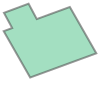

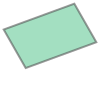

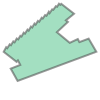

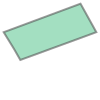

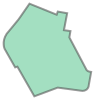

In [48]:
shapely_geoms = {}
for index, _geom in zip(row_indices, geoms):
    shapely_geom = shapely_from_wkb(_geom)
    shapely_geoms[index] = shapely_geom
    display(shapely_geom)

Hmm, interesting. It may or may not be obvious which of these is our building of interest, but either way let's treat this as a problem to solve robustly. We've done really inexpensive bounding box comparisons up until now to filter down the set of possibilities as cheaply as possible. Now that we have some actual contenders, we should switch to th more expensive comparison of the geometries themselves.

To facilitate this comparison, let's also load our geometry into shapely.

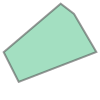

In [49]:
our_geom = shapely_from_geojson(json.dumps(geom))
display(our_geom)

With shapely geometries on either side, we can find all geometries that intersect our geometry.

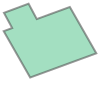

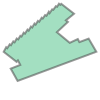

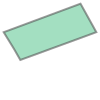

In [50]:
for _geom in shapely_geoms.values():
    if _geom.intersects(our_geom):
        display(_geom)

Hmm, well, we've narrowed it down. But still, we need to do better. How can we estimate similarity? Perhaps if we calculate the actual intersection as a geometry, we could measure its area? The larger the intersecting area, the more likely the geometry is our target building? After all, we might expect some overlaps around the edges that could cause intersecting slivers, but we should not have buildings overlapping in the Overture dataset.

So let's try that out and see what happens.

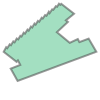

The row that most intersects our geometry is 31967 of row group 35 in https://overturemaps-us-west-2.s3.us-west-2.amazonaws.com/release/2025-09-24.0/theme=buildings/type=building/part-00085-93d280c5-9152-4ecc-b500-d9681495941f-c000.zstd.parquet


In [51]:
max_intersection_area = 0
max_intersecting_geom = None
max_intersecting_index = None

for index, _geom in shapely_geoms.items():
    area = intersection(_geom, our_geom).area
    if area > max_intersection_area:
        max_intersection_area = area
        max_intersecting_geom = _geom
        max_intersecting_index = index

display(max_intersecting_geom)
print(f'The row that most intersects our geometry is {max_intersecting_index} of row group {row_group_index} in {file_url}')

Look at that! We've narrowed it down to a single row. Does this look like it is the right row?

## Questions

* How effective was parquet's support for predicate pushdown in our search? Can the access efficiency be quantified for this particular scenario?
* Using what you learned through this exercise, can you classify what types of problems parquet supports well?
* What about what parquet would be bad at? What are the trade-offs of parquet? What might be done to mitigate its trade-offs? What cannot be mitigated?
* Is parquet a true cloud-native format? Some argue that it is not. Can you make a case for why it is? What about why it might not be?
* What would it take to write a generic client for this access pattern? What about others? What would it take to make a truly general purpose query engine for parquet?